## Gerekli kütüphanelerin yüklenmesi

In [ ]:
import numpy as np # Dizi ve matris işlemleri için özelleşmiş bir kütüphanedir.
import matplotlib.pyplot as plt #Grafikleştirme işlemleri için kullanılan kütüphanedir.
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#Eğitim öncesi görüntü ayarlarını yapmak için kullanılır.
#Görüntü artırma, ölçeklendirme gibi işlemler.
from tensorflow.keras.applications import ResNet50
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras.backend as K

In [35]:
import glob, os#dosya işlemleri için kullanılan kütüphanelerdir.
import random 

## Veri setinin yüklenmesi

In [36]:
#Dosya yolu
base_path = r"C:\Users\Turan\Desktop\DerinOgrenme\TezCalismalari\veriseti\Garbage classification\garbage classification\Garbage classification"
#dosyadan okunan fotoğrafların yüklendiği değişken
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))#okunan fotoğraf sayısı

2527


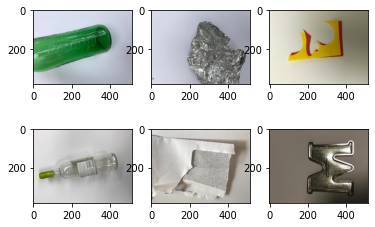

In [37]:
#Verisetinden örnek bir kaç görüntü
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

## Veri setinin modelin girişine hazırlanması ve bölünmesi

In [38]:
train_datagen = ImageDataGenerator(validation_split=0.3,#Veri setini bölme oranı
                                   preprocessing_function=preprocess_input)#Görüntü ön işlemi
#rescale = 1./255 kullanmak bu model için elverişsiz oluyor.

train_generator = train_datagen.flow_from_directory(base_path,
                                                     target_size=(224,224),#Fotoğrafın kaça kaç olacağı
                                                     batch_size=32,
                                                     shuffle=True,
                                                     class_mode='categorical',#Sınıfların sırasını kontrol etmek için kullanılır
                                                     subset='training')#Alt küme ayarlama validation/training

validation_datagen = ImageDataGenerator(validation_split=0.3,
                                        preprocessing_function=preprocess_input)

validation_generator =  validation_datagen.flow_from_directory(base_path,
                                                                target_size=(224,224),
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                subset='validation')  

Found 1771 images belonging to 6 classes.
Found 756 images belonging to 6 classes.


## ResNet50 modelinin yüklenmesi

In [39]:
base_model = ResNet50(weights='imagenet',#İmageNet'in ağırlıklarını yükler.
                      include_top=False, 
                      input_shape=(224, 224, 3))#Görüntünün giriş boyutu
base_model.trainable = False

## Yeni model oluşturma

In [40]:
import tensorflow as tf
from keras.models import Sequential#Model oluşturmayı sağlar.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
#Konvolüsyon,Flatten(Düzleştirme),Havuzlama(MAX),Dropout ve Normal katmanların kullanımını sağlar.

model = Sequential([#Model oluşturma
    base_model,#Giriş modeli (Functional)
    GlobalAveragePooling2D(),#Havuzlama Katmanı
    Dropout(0.15),
    #Flatten(),
    Dense(512, activation='relu'),#Tam bağlı katman
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(6, use_bias=False, activation='linear', name='svm')
    #Dense(6, activation='softmax')#Çıkış katmanı
])

## SVM için hazırlanan kayıp fonksiyonu

In [41]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

## Modelin derlenmesi ve optimizasyon ayarları

In [42]:
metrics = ['accuracy']
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5)
optimizer = tf.optimizers.Adam(1.e-5)

model.compile(optimizer=optimizer, loss=svm_loss(model.get_layer('svm')), metrics=metrics)


In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
svm (Dense)                  (None, 6)                

In [44]:
batch_size = 64 #32
epochs = 200 #İterasyon sayısı
#bir iterasyonda verilecek train ve test verilerinin oranlanması

In [45]:
#bir iterasyonda verilecek train ve test verilerinin oranlanması
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = "model_resnet50_{epoch:02d}-{val_accuracy:.2f}.h5"#Kaydedilecek modelin adı
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=75)#Aşırı öğrenmeyi önlemek için kullanılır.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Modelin test verisi üzerinde başarısı her arttığında kaydetme işlemini yapar.
callbacks_list = [es, checkpoint1]#Eğitime verilmek için liste haline getirildi.

## modelin eğitilmesi

In [47]:
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/200
27/27 [==============================] - 15s 413ms/step - loss: 6.7073 - accuracy: 0.1616 - val_loss: 6.5292 - val_accuracy: 0.3324

Epoch 00001: val_accuracy improved from -inf to 0.33239, saving model to model_resnet50_01-0.33.h5
Epoch 2/200
27/27 [==============================] - 10s 378ms/step - loss: 6.5720 - accuracy: 0.2842 - val_loss: 6.4640 - val_accuracy: 0.4261

Epoch 00002: val_accuracy improved from 0.33239 to 0.42614, saving model to model_resnet50_02-0.43.h5
Epoch 3/200
27/27 [==============================] - 10s 378ms/step - loss: 6.4604 - accuracy: 0.4330 - val_loss: 6.4166 - val_accuracy: 0.5057

Epoch 00003: val_accuracy improved from 0.42614 to 0.50568, saving model to model_resnet50_03-0.51.h5
Epoch 4/200
27/27 [==============================] - 10s 373ms/step - loss: 6.4360 - accuracy: 0.4826 - val_loss: 6.3604 - val_accuracy: 0.5909

Epoch 00004: val_accuracy improved from 0.50568 to 0.59091, saving model to model_resnet50_04-0.59.h5
Epoch 5/200
27/

27/27 [==============================] - 10s 380ms/step - loss: 6.1196 - accuracy: 0.8864 - val_loss: 6.2350 - val_accuracy: 0.7557

Epoch 00039: val_accuracy did not improve from 0.78125
Epoch 40/200
27/27 [==============================] - 10s 378ms/step - loss: 6.1076 - accuracy: 0.9089 - val_loss: 6.2291 - val_accuracy: 0.7699

Epoch 00040: val_accuracy did not improve from 0.78125
Epoch 41/200
27/27 [==============================] - 10s 374ms/step - loss: 6.1127 - accuracy: 0.9029 - val_loss: 6.2093 - val_accuracy: 0.7812

Epoch 00041: val_accuracy did not improve from 0.78125
Epoch 42/200
27/27 [==============================] - 11s 396ms/step - loss: 6.1333 - accuracy: 0.8951 - val_loss: 6.2263 - val_accuracy: 0.7557

Epoch 00042: val_accuracy did not improve from 0.78125
Epoch 43/200
27/27 [==============================] - 10s 375ms/step - loss: 6.1113 - accuracy: 0.9138 - val_loss: 6.2189 - val_accuracy: 0.7699

Epoch 00043: val_accuracy did not improve from 0.78125
Epoch 44


Epoch 00119: val_accuracy did not improve from 0.82670
Epoch 120/200
27/27 [==============================] - 10s 378ms/step - loss: 6.0420 - accuracy: 0.9790 - val_loss: 6.2148 - val_accuracy: 0.7869

Epoch 00120: val_accuracy did not improve from 0.82670
Epoch 121/200
27/27 [==============================] - 10s 378ms/step - loss: 6.0359 - accuracy: 0.9847 - val_loss: 6.1946 - val_accuracy: 0.8153

Epoch 00121: val_accuracy did not improve from 0.82670
Epoch 122/200
27/27 [==============================] - 10s 382ms/step - loss: 6.0396 - accuracy: 0.9745 - val_loss: 6.2172 - val_accuracy: 0.7898

Epoch 00122: val_accuracy did not improve from 0.82670
Epoch 123/200
27/27 [==============================] - 10s 376ms/step - loss: 6.0507 - accuracy: 0.9680 - val_loss: 6.1907 - val_accuracy: 0.8352

Epoch 00123: val_accuracy improved from 0.82670 to 0.83523, saving model to model_resnet50_123-0.84.h5
Epoch 124/200
27/27 [==============================] - 10s 377ms/step - loss: 6.0415 - a

27/27 [==============================] - 10s 384ms/step - loss: 6.0372 - accuracy: 0.9798 - val_loss: 6.2140 - val_accuracy: 0.8097

Epoch 00160: val_accuracy did not improve from 0.84659
Epoch 161/200
27/27 [==============================] - 10s 383ms/step - loss: 6.0259 - accuracy: 0.9930 - val_loss: 6.1799 - val_accuracy: 0.8324

Epoch 00161: val_accuracy did not improve from 0.84659
Epoch 162/200
27/27 [==============================] - 10s 379ms/step - loss: 6.0334 - accuracy: 0.9851 - val_loss: 6.1965 - val_accuracy: 0.8125

Epoch 00162: val_accuracy did not improve from 0.84659
Epoch 163/200
27/27 [==============================] - 10s 385ms/step - loss: 6.0306 - accuracy: 0.9905 - val_loss: 6.2048 - val_accuracy: 0.7955

Epoch 00163: val_accuracy did not improve from 0.84659
Epoch 164/200
27/27 [==============================] - 10s 379ms/step - loss: 6.0321 - accuracy: 0.9906 - val_loss: 6.2070 - val_accuracy: 0.7869

Epoch 00164: val_accuracy did not improve from 0.84659
Epoc


Epoch 00200: val_accuracy did not improve from 0.84659


## Sonuçlar 

In [48]:
score = model.evaluate(validation_generator,batch_size=32)#Modeli test verisi ile dener.
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))#Sonucu yüzdeye uyarlar.

24/24 [==============================] - 6s 262ms/step - loss: 6.1975 - accuracy: 0.8175
Score Accuracy : 81.75%


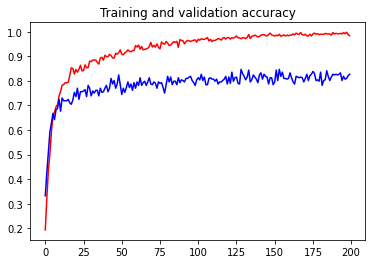

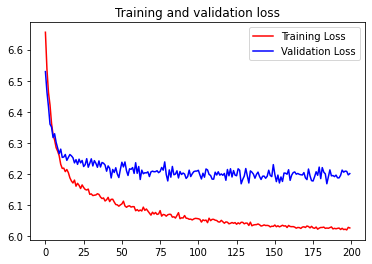

In [49]:
#Eğitim sürecinin görselleştirilmesi
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()